In [1]:
import tensorflow as tf
import os
import numpy as np
import warnings
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

tf.keras.backend.clear_session()

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def unet_model(input_size = (256, 256, 3), mult = 1, dropout = 0.1):
    
    inputs = tf.keras.layers.Input(input_size)
    
    # inputs = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    
    c1 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Dropout(dropout)(c1)
    c1 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Dropout(dropout)(c2)
    c2 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Dropout(dropout)(c3)
    c3 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    p3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Dropout(dropout)(c4)
    c4 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(filters = 256 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Dropout(dropout)(c5)
    c5 = tf.keras.layers.Conv2D(filters = 256 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = tf.keras.layers.BatchNormalization()(c5)

    u6 = tf.keras.layers.Conv2DTranspose(filters = 128 * mult, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4], axis = 3)
    c6 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Dropout(dropout)(c6)
    c6 = tf.keras.layers.Conv2D(filters = 128 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = tf.keras.layers.BatchNormalization()(c6)

    u7 = tf.keras.layers.Conv2DTranspose(filters = 64 * mult, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3], axis = 3)
    c7 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Dropout(dropout)(c7)
    c7 = tf.keras.layers.Conv2D(filters = 64 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = tf.keras.layers.BatchNormalization()(c7)

    u8 = tf.keras.layers.Conv2DTranspose(filters = 32 * mult, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2], axis = 3)
    c8 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Dropout(dropout)(c8)
    c8 = tf.keras.layers.Conv2D(filters = 32 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = tf.keras.layers.BatchNormalization()(c8)

    u9 = tf.keras.layers.Conv2DTranspose(filters = 16 * mult, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
    c9 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Dropout(dropout)(c9)
    c9 = tf.keras.layers.Conv2D(filters = 16 * mult, kernel_size = (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = tf.keras.layers.BatchNormalization()(c9)

    outputs = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1, 1), activation = 'sigmoid')(c9)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    
    # print(model.summary())

    return model

# Single model

In [4]:
tf.keras.backend.clear_session()
model = unet_model(input_size = (256, 256, 3), mult = 1, dropout = 0.1)
model.load_weights("D:/GitHub/Datasets/MassachusettsRoads/model_mult_1_256_crops_drop_empty.h5")
model.compile(optimizer = "adam",
              loss = "binary_crossentropy")

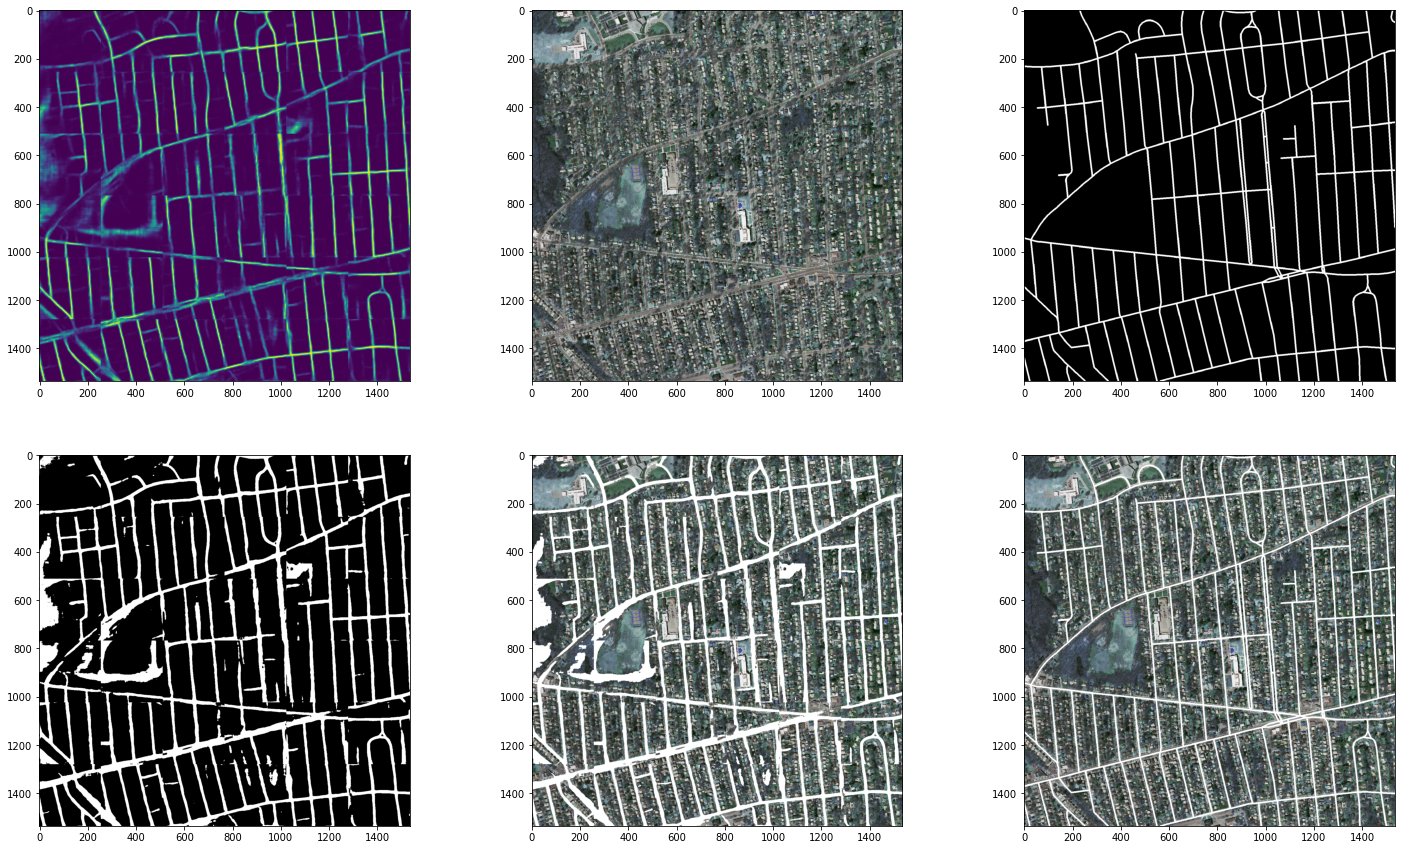

In [5]:
tf.keras.backend.clear_session()

dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
images = os.path.join(dataset_path, "Images")
masks = os.path.join(dataset_path, "Masks")

id = 127
image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

if image.shape[0] == 1024:
     rows = 4
if image.shape[0] == 1500:
     rows = 6

if image.shape[1] == 1024:
     cols = 4
if image.shape[1] == 1500:
     cols = 6

if rows == 6 & cols == 6:
    image = cv2.resize(image, (rows * 256, cols * 256), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (rows * 256, cols * 256), interpolation = cv2.INTER_NEAREST)

rows_ = np.round(image.shape[0]/rows)
rows_indices = [0]

for i in np.arange(0, rows):
    if i < rows - 1:
        rows_indices.append(int((i + 1) * rows_))
    else:
        rows_indices.append(int(image.shape[0]))

rows_indices

cols_ = np.round(image.shape[1]/cols)
cols_indices = [0]

for i in np.arange(0, cols):
    if i < cols - 1:
        cols_indices.append(int((i + 1) * cols_))
    else:
         cols_indices.append(int(image.shape[1]))

images_ = []
masks_ = []

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]

        image_ = image[i_start:i_end, j_start:j_end, :]
        images_.append(image_)
        images__ = np.array(images_)
        images__ = images__/255
        mask_ = mask[i_start:i_end, j_start:j_end, :]
        masks_.append(mask_)
        masks__ = np.array(masks_)

prediction_output = np.zeros((image.shape[0], image.shape[1], 1))

prediction = model.predict(images__) * 255

width = len(rows_indices) - 1

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]

        # print(i, j, (i * width) + (j + 1), i_start, i_end, j_start, j_end)
        prediction_output[i_start:i_end, j_start:j_end, :] = prediction[(i * width) + (j + 1) - 1,:, :, :] 

cutoff = np.mean(np.ravel(mask))
pridiction_output_binary = prediction_output > cutoff
pridiction_output_binary = pridiction_output_binary.astype('uint8')
pridiction_output_binary = pridiction_output_binary * 255
pridiction_output_binary = np.concatenate([pridiction_output_binary, pridiction_output_binary, pridiction_output_binary], axis = -1)

image_mask = cv2.addWeighted(image, 1, mask, 1, 1)
image_prediction = cv2.addWeighted(image, 1, pridiction_output_binary, 1, 1)

fig = plt.figure(figsize = (25, 15))
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(prediction_output)
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(image)
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(mask)
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(pridiction_output_binary)
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(image_prediction)
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(image_mask)
plt.show() 

# Ensemble model

In [4]:
tf.keras.backend.clear_session()

model_1 = unet_model(input_size = (256, 256, 3), mult = 1, dropout = 0.1)
model_1.load_weights("D:/GitHub/Datasets/MassachusettsRoads/model_mult_1_256_crops_drop_empty.h5")
model_1.compile(optimizer = "adam", loss = "binary_crossentropy")

model_2 = unet_model(input_size = (256, 256, 3), mult = 2, dropout = 0.1)
model_2.load_weights("D:/GitHub/Datasets/MassachusettsRoads/model_mult_2_256_crops_drop_empty.h5")
model_2.compile(optimizer = "adam", loss = "binary_crossentropy")

model_3 = unet_model(input_size = (256, 256, 3), mult = 3, dropout = 0.1)
model_3.load_weights("D:/GitHub/Datasets/MassachusettsRoads/model_mult_3_256_crops_drop_empty.h5")
model_3.compile(optimizer = "adam", loss = "binary_crossentropy")

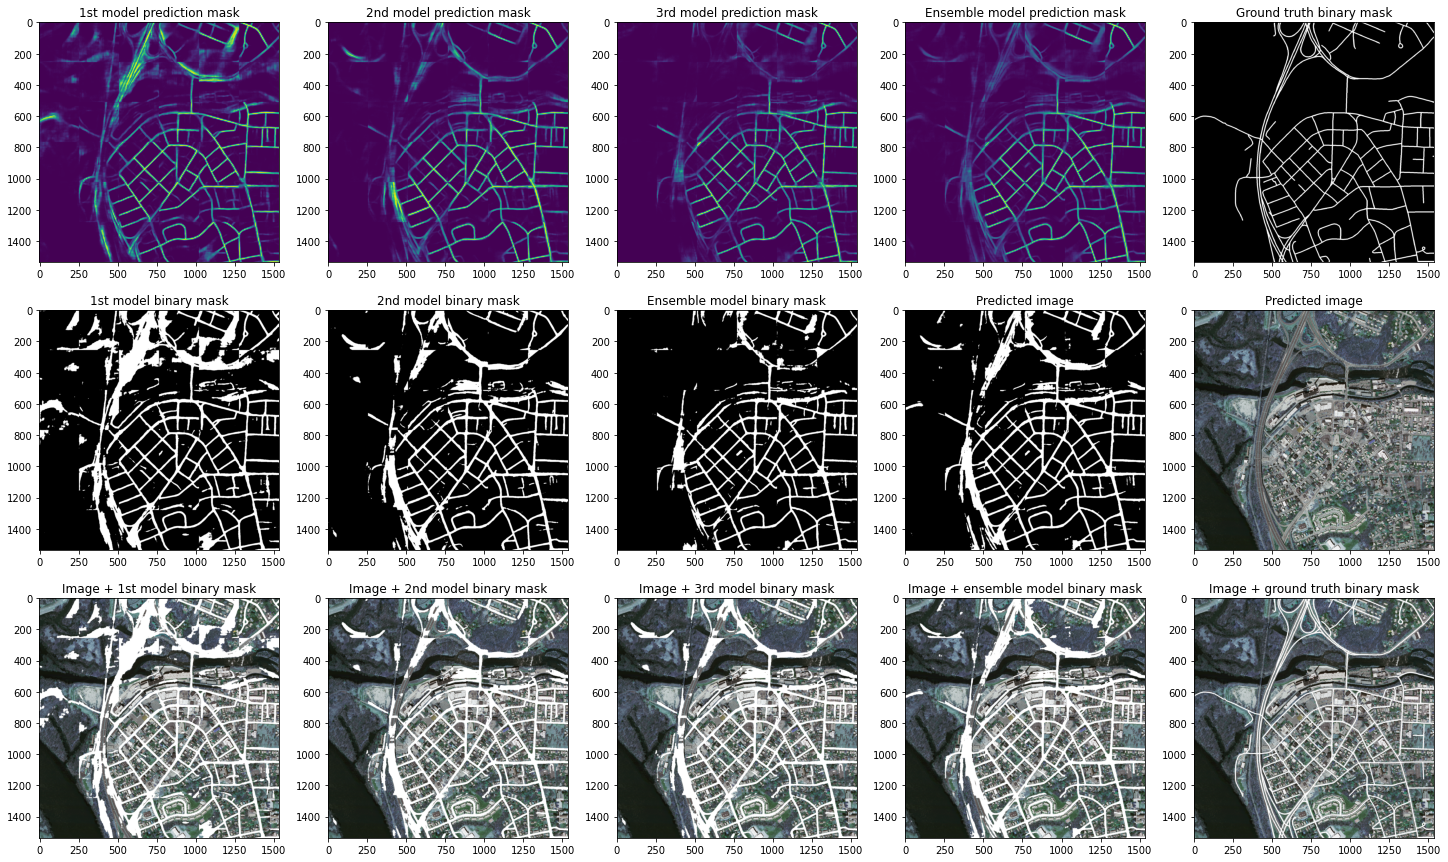

In [5]:
tf.keras.backend.clear_session()

dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
images = os.path.join(dataset_path, "Images")
masks = os.path.join(dataset_path, "Masks")

id = 57
image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

if image.shape[0] == 1024:
     rows = 4
if image.shape[0] == 1500:
     rows = 6

if image.shape[1] == 1024:
     cols = 4
if image.shape[1] == 1500:
     cols = 6

if rows == 6 & cols == 6:
    image = cv2.resize(image, (rows * 256, cols * 256), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (rows * 256, cols * 256), interpolation = cv2.INTER_NEAREST)

rows_ = np.round(image.shape[0]/rows)
rows_indices = [0]

for i in np.arange(0, rows):
    if i < rows - 1:
        rows_indices.append(int((i + 1) * rows_))
    else:
        rows_indices.append(int(image.shape[0]))

rows_indices

cols_ = np.round(image.shape[1]/cols)
cols_indices = [0]

for i in np.arange(0, cols):
    if i < cols - 1:
        cols_indices.append(int((i + 1) * cols_))
    else:
         cols_indices.append(int(image.shape[1]))

images_ = []
masks_ = []

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]

        image_ = image[i_start:i_end, j_start:j_end, :]
        images_.append(image_)
        images__ = np.array(images_)
        images__ = images__/255
        mask_ = mask[i_start:i_end, j_start:j_end, :]
        masks_.append(mask_)
        masks__ = np.array(masks_)

prediction_output_1 = np.zeros((image.shape[0], image.shape[1], 1))
prediction_output_2 = np.zeros((image.shape[0], image.shape[1], 1))
prediction_output_3 = np.zeros((image.shape[0], image.shape[1], 1))
prediction_output = np.zeros((image.shape[0], image.shape[1], 1))

prediction_1 = model_1.predict(images__) * 255
prediction_2 = model_2.predict(images__) * 255
prediction_3 = model_3.predict(images__) * 255

model_1_weight = 1/6
model_2_weight = 2/6
model_3_weight = 3/6
prediction = prediction_1 * model_1_weight + prediction_2 * model_2_weight + prediction_3 * model_3_weight 

width = len(rows_indices) - 1

for i in np.arange(len(rows_indices) - 1):
    i_start = rows_indices[i]
    i_end = rows_indices[i + 1]

    for j in np.arange(len(cols_indices) - 1):
        j_start = cols_indices[j]
        j_end = cols_indices[j + 1]

        # print(i, j, (i * width) + (j + 1), i_start, i_end, j_start, j_end)
        prediction_output_1[i_start:i_end, j_start:j_end, :] = prediction_1[(i * width) + (j + 1) - 1,:, :, :]
        prediction_output_2[i_start:i_end, j_start:j_end, :] = prediction_2[(i * width) + (j + 1) - 1,:, :, :]
        prediction_output_3[i_start:i_end, j_start:j_end, :] = prediction_3[(i * width) + (j + 1) - 1,:, :, :]
        prediction_output[i_start:i_end, j_start:j_end, :] = prediction[(i * width) + (j + 1) - 1,:, :, :]

cutoff = np.mean(np.ravel(mask))
pridiction_output_1_binary = prediction_output_1 > cutoff
pridiction_output_1_binary = pridiction_output_1_binary.astype('uint8')
pridiction_output_1_binary = pridiction_output_1_binary * 255
pridiction_output_1_binary = np.concatenate([pridiction_output_1_binary, pridiction_output_1_binary, pridiction_output_1_binary], axis = -1)

pridiction_output_2_binary = prediction_output_2 > cutoff
pridiction_output_2_binary = pridiction_output_2_binary.astype('uint8')
pridiction_output_2_binary = pridiction_output_2_binary * 255
pridiction_output_2_binary = np.concatenate([pridiction_output_2_binary, pridiction_output_2_binary, pridiction_output_2_binary], axis = -1)

pridiction_output_3_binary = prediction_output_3 > cutoff
pridiction_output_3_binary = pridiction_output_3_binary.astype('uint8')
pridiction_output_3_binary = pridiction_output_3_binary * 255
pridiction_output_3_binary = np.concatenate([pridiction_output_3_binary, pridiction_output_3_binary, pridiction_output_3_binary], axis = -1)

pridiction_output_binary = prediction_output > cutoff
pridiction_output_binary = pridiction_output_binary.astype('uint8')
pridiction_output_binary = pridiction_output_binary * 255
pridiction_output_binary = np.concatenate([pridiction_output_binary, pridiction_output_binary, pridiction_output_binary], axis = -1)
        
prediction_1_mask = cv2.addWeighted(image, 1, pridiction_output_1_binary, 1, 1)
prediction_2_mask = cv2.addWeighted(image, 1, pridiction_output_2_binary, 1, 1)
prediction_3_mask = cv2.addWeighted(image, 1, pridiction_output_3_binary, 1, 1)
prediction_mask = cv2.addWeighted(image, 1, pridiction_output_binary, 1, 1)
image_mask = cv2.addWeighted(image, 1, mask, 1, 1)

fig = plt.figure(figsize = (25, 15))
ax1 = fig.add_subplot(3, 5, 1)
ax1.imshow(prediction_output_1)
plt.title("1st model prediction mask")
ax2 = fig.add_subplot(3, 5, 2)
ax2.imshow(prediction_output_2)
plt.title("2nd model prediction mask")
ax3 = fig.add_subplot(3, 5, 3)
ax3.imshow(prediction_output_3)
plt.title("3rd model prediction mask")
ax4 = fig.add_subplot(3, 5, 4)
ax4.imshow(prediction_output)
plt.title("Ensemble model prediction mask")
ax4 = fig.add_subplot(3, 5, 5)
ax4.imshow(mask)
plt.title("Ground truth binary mask")

ax6 = fig.add_subplot(3, 5, 6)
ax6.imshow(pridiction_output_1_binary)
plt.title("1st model binary mask")
ax7 = fig.add_subplot(3, 5, 7)
ax7.imshow(pridiction_output_2_binary)
plt.title("2nd model binary mask")
ax8 = fig.add_subplot(3, 5, 8)
ax8.imshow(pridiction_output_3_binary)
plt.title("Ensemble model binary mask")
ax9 = fig.add_subplot(3, 5, 9)
ax9.imshow(pridiction_output_binary)
plt.title("Predicted image")
ax10 = fig.add_subplot(3, 5, 10)
ax10.imshow(image)
plt.title("Predicted image")

ax11 = fig.add_subplot(3, 5, 11)
ax11.imshow(prediction_1_mask)
plt.title("Image + 1st model binary mask")
ax12 = fig.add_subplot(3, 5, 12)
ax12.imshow(prediction_2_mask)
plt.title("Image + 2nd model binary mask")
ax13 = fig.add_subplot(3, 5, 13)
ax13.imshow(prediction_2_mask)
plt.title("Image + 3rd model binary mask")
ax14 = fig.add_subplot(3, 5, 14)
ax14.imshow(prediction_mask)
plt.title("Image + ensemble model binary mask")
ax15 = fig.add_subplot(3, 5, 15)
ax15.imshow(image_mask)
plt.title("Image + ground truth binary mask")
plt.show()

0


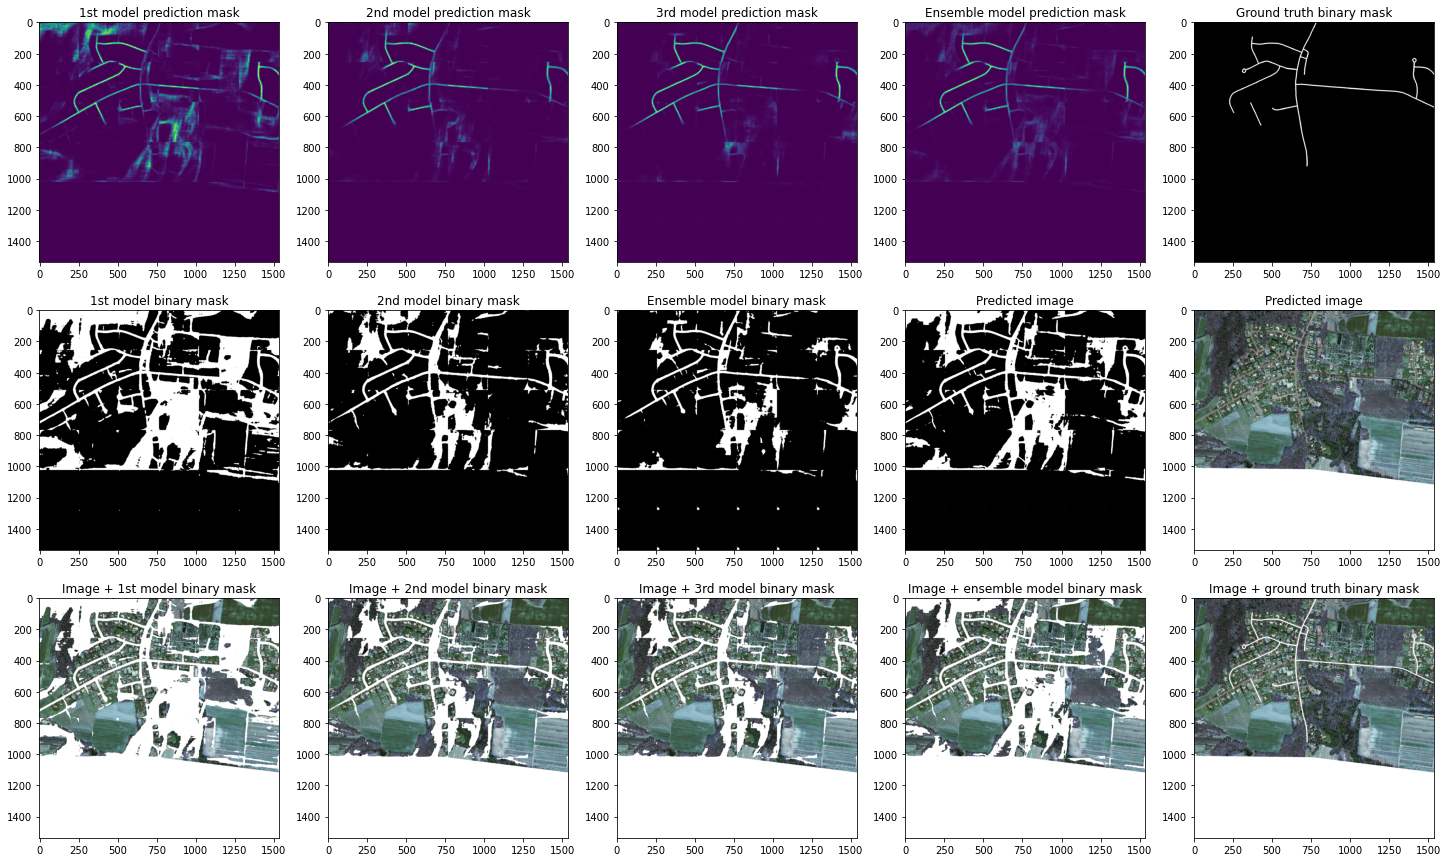

In [6]:
tf.keras.backend.clear_session()

dataset_path = "D:/GitHub/Datasets/MassachusettsRoads"
images = os.path.join(dataset_path, "Images")
masks = os.path.join(dataset_path, "Masks")

for i in np.arange(1):
    print(i)
    id = i
    image = cv2.imread(os.path.join(images, os.listdir(images)[id]))
    mask = cv2.imread(os.path.join(masks, os.listdir(masks)[id]))

    if image.shape[0] == 1024:
         rows = 4
    if image.shape[0] == 1500:
         rows = 6

    if image.shape[1] == 1024:
         cols = 4
    if image.shape[1] == 1500:
         cols = 6

    if rows == 6 & cols == 6:
        image = cv2.resize(image, (rows * 256, cols * 256), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (rows * 256, cols * 256), interpolation = cv2.INTER_NEAREST)

    rows_ = np.round(image.shape[0]/rows)
    rows_indices = [0]

    for i in np.arange(0, rows):
        if i < rows - 1:
            rows_indices.append(int((i + 1) * rows_))
        else:
            rows_indices.append(int(image.shape[0]))

    rows_indices

    cols_ = np.round(image.shape[1]/cols)
    cols_indices = [0]

    for i in np.arange(0, cols):
        if i < cols - 1:
            cols_indices.append(int((i + 1) * cols_))
        else:
             cols_indices.append(int(image.shape[1]))

    images_ = []
    masks_ = []

    for i in np.arange(len(rows_indices) - 1):
        i_start = rows_indices[i]
        i_end = rows_indices[i + 1]

        for j in np.arange(len(cols_indices) - 1):
            j_start = cols_indices[j]
            j_end = cols_indices[j + 1]

            image_ = image[i_start:i_end, j_start:j_end, :]
            images_.append(image_)
            images__ = np.array(images_)
            images__ = images__/255
            mask_ = mask[i_start:i_end, j_start:j_end, :]
            masks_.append(mask_)
            masks__ = np.array(masks_)

    prediction_output_1 = np.zeros((image.shape[0], image.shape[1], 1))
    prediction_output_2 = np.zeros((image.shape[0], image.shape[1], 1))
    prediction_output_3 = np.zeros((image.shape[0], image.shape[1], 1))
    prediction_output = np.zeros((image.shape[0], image.shape[1], 1))

    prediction_1 = model_1.predict(images__) * 255
    prediction_2 = model_2.predict(images__) * 255
    prediction_3 = model_3.predict(images__) * 255

    model_1_weight = 1/6
    model_2_weight = 2/6
    model_3_weight = 3/6
    prediction = prediction_1 * model_1_weight + prediction_2 * model_2_weight + prediction_3 * model_3_weight 

    width = len(rows_indices) - 1

    for i in np.arange(len(rows_indices) - 1):
        i_start = rows_indices[i]
        i_end = rows_indices[i + 1]

        for j in np.arange(len(cols_indices) - 1):
            j_start = cols_indices[j]
            j_end = cols_indices[j + 1]

            # print(i, j, (i * width) + (j + 1), i_start, i_end, j_start, j_end)
            prediction_output_1[i_start:i_end, j_start:j_end, :] = prediction_1[(i * width) + (j + 1) - 1,:, :, :]
            prediction_output_2[i_start:i_end, j_start:j_end, :] = prediction_2[(i * width) + (j + 1) - 1,:, :, :]
            prediction_output_3[i_start:i_end, j_start:j_end, :] = prediction_3[(i * width) + (j + 1) - 1,:, :, :]
            prediction_output[i_start:i_end, j_start:j_end, :] = prediction[(i * width) + (j + 1) - 1,:, :, :]

    cutoff = np.mean(np.ravel(mask))
    pridiction_output_1_binary = prediction_output_1 > cutoff
    pridiction_output_1_binary = pridiction_output_1_binary.astype('uint8')
    pridiction_output_1_binary = pridiction_output_1_binary * 255
    pridiction_output_1_binary = np.concatenate([pridiction_output_1_binary, pridiction_output_1_binary, pridiction_output_1_binary], axis = -1)

    pridiction_output_2_binary = prediction_output_2 > cutoff
    pridiction_output_2_binary = pridiction_output_2_binary.astype('uint8')
    pridiction_output_2_binary = pridiction_output_2_binary * 255
    pridiction_output_2_binary = np.concatenate([pridiction_output_2_binary, pridiction_output_2_binary, pridiction_output_2_binary], axis = -1)

    pridiction_output_3_binary = prediction_output_3 > cutoff
    pridiction_output_3_binary = pridiction_output_3_binary.astype('uint8')
    pridiction_output_3_binary = pridiction_output_3_binary * 255
    pridiction_output_3_binary = np.concatenate([pridiction_output_3_binary, pridiction_output_3_binary, pridiction_output_3_binary], axis = -1)

    pridiction_output_binary = prediction_output > cutoff
    pridiction_output_binary = pridiction_output_binary.astype('uint8')
    pridiction_output_binary = pridiction_output_binary * 255
    pridiction_output_binary = np.concatenate([pridiction_output_binary, pridiction_output_binary, pridiction_output_binary], axis = -1)

    prediction_1_mask = cv2.addWeighted(image, 1, pridiction_output_1_binary, 1, 1)
    prediction_2_mask = cv2.addWeighted(image, 1, pridiction_output_2_binary, 1, 1)
    prediction_3_mask = cv2.addWeighted(image, 1, pridiction_output_3_binary, 1, 1)
    prediction_mask = cv2.addWeighted(image, 1, pridiction_output_binary, 1, 1)
    image_mask = cv2.addWeighted(image, 1, mask, 1, 1)

    fig = plt.figure(figsize = (25, 15))
    ax1 = fig.add_subplot(3, 5, 1)
    ax1.imshow(prediction_output_1)
    plt.title("1st model prediction mask")
    ax2 = fig.add_subplot(3, 5, 2)
    ax2.imshow(prediction_output_2)
    plt.title("2nd model prediction mask")
    ax3 = fig.add_subplot(3, 5, 3)
    ax3.imshow(prediction_output_3)
    plt.title("3rd model prediction mask")
    ax4 = fig.add_subplot(3, 5, 4)
    ax4.imshow(prediction_output)
    plt.title("Ensemble model prediction mask")
    ax4 = fig.add_subplot(3, 5, 5)
    ax4.imshow(mask)
    plt.title("Ground truth binary mask")

    ax6 = fig.add_subplot(3, 5, 6)
    ax6.imshow(pridiction_output_1_binary)
    plt.title("1st model binary mask")
    ax7 = fig.add_subplot(3, 5, 7)
    ax7.imshow(pridiction_output_2_binary)
    plt.title("2nd model binary mask")
    ax8 = fig.add_subplot(3, 5, 8)
    ax8.imshow(pridiction_output_3_binary)
    plt.title("Ensemble model binary mask")
    ax9 = fig.add_subplot(3, 5, 9)
    ax9.imshow(pridiction_output_binary)
    plt.title("Predicted image")
    ax10 = fig.add_subplot(3, 5, 10)
    ax10.imshow(image)
    plt.title("Predicted image")

    ax11 = fig.add_subplot(3, 5, 11)
    ax11.imshow(prediction_1_mask)
    plt.title("Image + 1st model binary mask")
    ax12 = fig.add_subplot(3, 5, 12)
    ax12.imshow(prediction_2_mask)
    plt.title("Image + 2nd model binary mask")
    ax13 = fig.add_subplot(3, 5, 13)
    ax13.imshow(prediction_2_mask)
    plt.title("Image + 3rd model binary mask")
    ax14 = fig.add_subplot(3, 5, 14)
    ax14.imshow(prediction_mask)
    plt.title("Image + ensemble model binary mask")
    ax15 = fig.add_subplot(3, 5, 15)
    ax15.imshow(image_mask)
    plt.title("Image + ground truth binary mask")
    plt.show()